# Fig. 6: S/N maps of key spectral templates

In [36]:
import pickle
from matplotlib import pyplot as plt
import os
from astropy import units as u
import sys
import numpy as np
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [37]:
def get_planet_params(data, trial_kp, trial_vsys):
    yy, xx = np.meshgrid(trial_kp, trial_vsys)
    indmax = np.unravel_index(data.argmax(), data.shape)
    vsys_max, kp_max = xx[indmax], yy[indmax]
    value_max = data[indmax]
    return vsys_max, kp_max, value_max

In [38]:
APJ_SINGLE_COL = 3.5
APJ_DOUBLE_COL = 7.
TEXTSIZE=12

In [39]:
def plot_detection_matrix(data, dkp_all, dvsys_all, kp, vsys, mode='snr', title='', interp_method='bicubic', ax='None', **kwargs):
    """Plot Kp-vsys map."""
    extend='neither'
    quantity = r'S/N'
    cmap = kwargs.pop('cmap', 'Reds_r')
    markercolor = 'w'
    snr_min = kwargs.pop('snr_min', np.nanmin(data))
    snr_max = kwargs.pop('snr_max', np.ceil(10*np.nanmax(data))/10.)

    snr_step = kwargs.pop('snr_step', 0.25)
    ncolors = int(1+(snr_max - snr_min)/snr_step)
    if ncolors > 256:
        ncolors = 256

    cmap = mpl.colormaps[cmap]
    cmap.set_bad('gray',1.)
    bounds = np.round(np.linspace(snr_min, snr_max, ncolors), 1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    # Create figure and axes
    sf=10
    if ax == 'None':
        fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH))
        gs = gridspec.GridSpec(1, 2, width_ratios=[0.95,0.035], wspace=0.025)
        ax = plt.subplot(gs[0,0])
        cax = plt.subplot(gs[0,1])
    else:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.0)

    # Set appropriate ranges
    dvsys = dvsys_all[1]-dvsys_all[0]
    dkp = dkp_all[1]-dkp_all[0]
    global extent
    extent=[
        (dvsys_all[0]-dvsys/2.)/1e3,
        (dvsys_all[-1]+dvsys/2.)/1e3,
        (dkp_all[0]-dkp/2.+kp)/1e3,
        (dkp_all[-1]+dkp/2.+kp)/1e3
    ]

    # Plot matrix
    im = ax.imshow(data.T, origin='lower',
                   extent=extent,
                   aspect='auto', cmap=cmap,
                   norm=norm, interpolation=interp_method)
    ax.tick_params(labelsize=TEXTSIZE)
    #ax.set_xlabel(r'System velocity (km/s)', size=TEXTSIZE)
    #ax.set_ylabel(r'$\rm{K}_{\rm{p}}$ (km/s)', size=TEXTSIZE)

    # Plot dotted lines to the planet's estimate (vsys, kp)
    bads = np.isnan(data)
    data_masked = np.copy(data)
    data_masked[bads] = 0.
    vsys_max, kp_max, value_max = get_planet_params(data_masked, kp+dkp_all, dvsys_all) # find min instead of max in this mode

    #vsys += 4e3
    ax.plot([vsys/1e3, vsys/1e3], [extent[2], (kp-15e3)/1e3], ls='--', color='w', lw=2, label='expected')
    ax.plot([vsys/1e3, vsys/1e3], [(kp+15e3)/1e3, extent[3]-25], ls='--', color='w', lw=2)
    ax.plot([extent[0], (vsys-10e3)/1e3], [kp/1e3, kp/1e3], ls='--', color='w', lw=2)
    ax.plot([(vsys+10e3)/1e3, extent[1]], [kp/1e3, kp/1e3], ls='--', color='w', lw=2)
    ax.scatter( (vsys_max)/1e3, (kp_max)/1e3, marker="8", s=20, facecolors='w', edgecolors='k', linewidths=0.5, label='maximum SNR')
    
    # Add text with highest SNR
    print(f'S/N_max, {value_max}')
    ax.annotate('{} = {:.1f}\n'.format(quantity, value_max),
                (0.5, 0.975), xycoords='axes fraction', ha='center', va='top', size=TEXTSIZE, color='w', fontweight='bold')

    # Plot colorbar
    cbar = plt.colorbar(mappable=im, cax=cax,extend=extend)
    #cbar.set_label('{}'.format(quantity), size=TEXTSIZE)
    cax.tick_params(labelsize=TEXTSIZE)

    # Set title
    #leg = ax.legend(fontsize=TEXTSIZE, frameon=False)
    #plt.setp(leg.get_texts(), color='w')
    ax.set_xlim(dvsys_all[0]/1e3, dvsys_all[-1]/1e3)
    ax.set_ylim(kp/1e3+dkp_all[0]/1e3, kp/1e3+dkp_all[-1]/1e3)
    return ax, cax, cbar

In [40]:
vsys = -20.82e3 * (u.m/u.s) # Yan 2020
kp = 197e3 * (u.m/u.s) # Aderson 2018

In [41]:
def gen_snr_plots(dirin_list, specie, cmap, plot_title, plot_contour=False):
    """Generate Kp-vsys S/N maps."""

    title_list = [
        f'{plot_title}',
        f'{plot_title} (night 1)',
        f'{plot_title} (night 2)'
    ]

    for dirin, title in zip(dirin_list, title_list):
        f = open(os.path.join(dirin, 'snrmap.pkl'), 'rb')
        trial_kp, trial_vsys, snrmatrix = pickle.load(f)

        fig, ax = plt.subplots(figsize=(APJ_SINGLE_COL, APJ_SINGLE_COL))
        
        if plot_contour:
            X, Y = np.meshgrid(trial_vsys/1e3 + vsys.to(u.km/u.s).value, trial_kp/1e3)
            plt.contour(X, Y, snrmatrix.T, color='r', levels=[snrmatrix.max()-1])

        ax, cax, cbar = plot_detection_matrix(
        data=snrmatrix,
        dkp_all=trial_kp-kp.to(u.m/u.s).value,
        dvsys_all=trial_vsys+vsys.to(u.m/u.s).value,
        kp=kp.to(u.m/u.s).value,
        vsys=vsys.to(u.m/u.s).value,
        cmap=cmap,
        ax=ax
        )
        ax.set_title(title, size=TEXTSIZE, fontweight='bold')
        ax.set_ylabel('Keplerian velocity [km/s]', size=TEXTSIZE)
        ax.set_xlabel('System velocity [km/s]', size=TEXTSIZE)
        cbar.set_label('S/N', size=TEXTSIZE)
        yield fig, ax

S/N_max, 6.3102246211134965


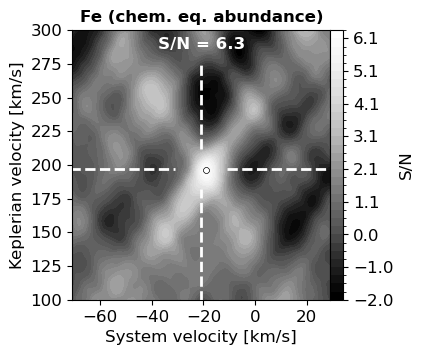

In [42]:
%matplotlib inline
specie = 'Fe'
dirin_list = [
    f'../data/xcor_out/WASP-189_2023A_2023_06_09_2024A_2024_04_19/W189b_pRT_1D_Yan22_chem_eq_{specie}/NPC_7_mp_70_ccw',
]
plt.close()
snr_plots = gen_snr_plots(
    dirin_list=dirin_list,
    specie=specie,
    cmap='Greys_r',
    plot_title='Fe (chem. eq. abundance)',
    plot_contour=False
)
extensions = ['']
for (fig, ax), ext in zip(snr_plots, extensions):
    plt.savefig(f'../figures/Fig6a_{specie}_snrmap{ext}.png', dpi=150, bbox_inches='tight')
    plt.savefig(f'../figures/Fig6b_{specie}_snrmap{ext}.pdf', bbox_inches='tight')
    plt.show()

S/N_max, 9.755002446863642


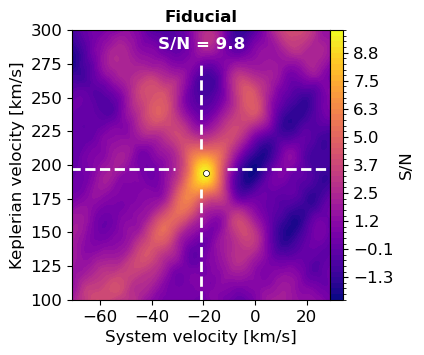

In [43]:
%matplotlib inline
specie = 'all'
dirin_list = [
    f'../data/xcor_out/WASP-189_2023A_2023_06_09_2024A_2024_04_19/W189b_pRT_1D_Yan22_chem_eq_{specie}/NPC_7_mp_70_ccw',
]
snr_plots = gen_snr_plots(
    dirin_list=dirin_list,
    specie=specie,
    cmap='plasma',
    plot_title='Fiducial',
    plot_contour=False
)
extensions = ['', '_night_1', '_night_2']
for (fig, ax), ext in zip(snr_plots, extensions):
    plt.savefig(f'../figures/Fig6b_fiducial_snrmap{ext}.png', dpi=150, bbox_inches='tight')
    plt.savefig(f'../figures/Fig6b_fiducial_snrmap{ext}.pdf', bbox_inches='tight')
    plt.show()

S/N_max, 7.221633577334607


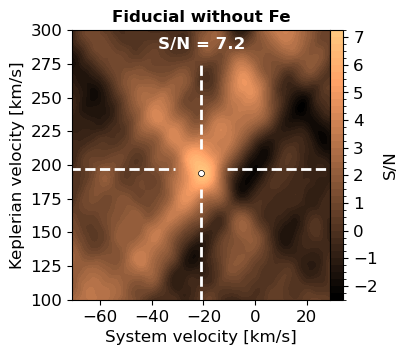

In [44]:
specie = 'without_Fe'
dirin_list = [
    f'../data/xcor_out/WASP-189_2023A_2023_06_09_2024A_2024_04_19/W189b_pRT_1D_Yan22_chem_eq_all_without_Fe/NPC_7_mp_70_ccw',
]
snr_plots = gen_snr_plots(
    dirin_list=dirin_list,
    specie=specie,
    cmap='copper',
    plot_title='Fiducial without Fe',
    plot_contour=False
)
extensions = ['']
for (fig, ax), ext in zip(snr_plots, extensions):
    
    plt.savefig(f'../figures/Fig6c_fiducial_without_Fe_snrmap{ext}.png', dpi=150, bbox_inches='tight')
    plt.savefig(f'../figures/Fig6c_fiducial_without_Fe_snrmap{ext}.pdf', bbox_inches='tight')
    plt.show()